# 1 Загрузка данных

In [ ]:
import os
import cv2
import json
import datetime
import scipy as sc
import numpy as np
from glob import glob
import tensorflow as tf
from random import shuffle
import matplotlib.pyplot as plt

Скачиваем датасет в рабочую директорию, информацию о датасете можно посмотреть на [сайте](https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/)

In [ ]:
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki.tar.gz

--2024-04-02 10:05:09--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3157487479 (2.9G) [application/x-gzip]
Saving to: ‘wiki.tar.gz’

wiki.tar.gz         100%[===================>]   2.94G  18.0MB/s    in 3m 0s   

2024-04-02 10:08:09 (16.8 MB/s) - ‘wiki.tar.gz’ saved [3157487479/3157487479]



In [ ]:
# Распаковываем архив
!tar -xzvf /content/wiki.tar.gz

Выходные данные были обрезаны до нескольких последних строк (5000).
wiki/50/8653450_1985-11-28_2014.jpg
wiki/50/28040650_1986-04-20_2011.jpg
wiki/50/1896450_1928-03-22_1990.jpg
wiki/50/39477450_1965-01-04_2014.jpg
wiki/50/17106250_1950-02-23_2010.jpg
wiki/50/17508150_1986-04-22_2012.jpg
wiki/50/15701850_1986-04-15_2010.jpg
wiki/50/28037450_1934-07-09_2002.jpg
wiki/50/14040750_1989-10-04_2008.jpg
wiki/50/28991050_1964-08-19_2010.jpg
wiki/50/27962750_1894-03-20_1946.jpg
wiki/50/29127850_1923-11-05_2007.jpg
wiki/50/33309450_1989-04-27_2012.jpg
wiki/50/20291650_1987-02-18_2014.jpg
wiki/50/2529850_1922-12-05_1966.jpg
wiki/50/42305150_1954-07-11_1950.jpg
wiki/50/22659150_1890-11-01_1962.jpg
wiki/50/29569950_1978-04-28_1999.jpg
wiki/50/7720450_1956-07-18_2010.jpg
wiki/50/7973150_1985-10-07_2009.jpg
wiki/50/2744250_1981-01-17_2010.jpg
wiki/50/166450_1927-06-15_1989.jpg
wiki/50/35796450_1936-01-21_1973.jpg
wiki/50/43761250_1941-04-20_1960.jpg
wiki/50/38389550_1970-03-25_1996.jpg
wiki/50/683150_

Читаем содержимое **wiki.mat** файла, это словарь с метаданными датасета

In [ ]:
meta = sc.io.loadmat("/content/wiki/wiki.mat")

In [ ]:
# Посмотрим как выглядит внутренняя структура словаря
meta['wiki'][0]

array([(array([[723671, 703186, 711677, ..., 720620, 723893, 713846]], dtype=int32), array([[2009, 1964, 2008, ..., 2013, 2011, 2008]], dtype=uint16), array([[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
               array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
               array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
               array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
               array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
               array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]],
             dtype=object), array([[1., 1., 1., ..., 1., 1., 0.]]), array([[array(['Sami Jauhojärvi'], dtype='<U15'),
               array(['Dettmar Cramer'], dtype='<U14'),
               array(['Marc Okrand'], dtype='<U11'), ...,
               array(['Michael Wiesinger'], dtype='<U17'),
               array(['Johann Grugger'], dtype='<U14'),
               array(['Greta Van Susteren'], dtype='<U18')]], dtype=ob

Посмотрим как можно найти информацию внутри этого словаря

In [ ]:
# Дата рождения человека на изображении
print(datetime.datetime.fromordinal(meta['wiki'][0]['dob'][0][0][0] - 366))

# Год сьемки фото
print(meta['wiki'][0]['photo_taken'][0][0][0])

# Гендер
print(meta['wiki'][0]['gender'][0][0][0])

# Имя файла и папки изображения
print(meta['wiki'][0]["full_path"][0][0][0][0])

1981-05-05 00:00:00
2009
1.0
17/10000217_1981-05-05_2009.jpg


Метаданные включают в себя:

- **dob**: Дата рождения человека на фото

- **photo_taken**: Год когда фото было сделано

- **full_path**: Путь к изображению

- **gender**: 0 для женщин и  1 для мужчин, NaN для неопределенных

- **name**: Имя

- **face_location**: Прямоугольник с координатами лица

- **face_score**: Качество исходной разметки (наличия лица на фото)

- **second_face_score**: Очки, наличие которых свидетельствует что на фото несколько людей.

# 2 Проверка и чистка данных

Предоставленные данные в основном являются данными сканирования, они не были подвержены предварительной проверке и обработке, поэтому нам нужно самим постараться найти все возможные выбросы, шумы, неточности или просто проблемные изображения и избавиться от них.

Какие случаи нужно точно удалить из данных, согластно авторам датасета?

- 18016 случаев, когда `face_score равен -inf`  

- 4096 случаев, когда `second_face_score не равен nan`. Если есть более одного лица

- Вычисленный возраст `age` отрицательный или превышает 100

- `gendeer` неопределен

Первым шагом приведем возраст человека на фото в удобный вид, так как на данный момент для каждого изображения указана дата рождения человека и дата сьемки - нужно сделать вычисления для того чтобы узнать точный возраст.

In [ ]:
def calc_age(taken, dob):
  """
  Функция вычисляет возраст человека на фотографии на основе даты его рождения
  и даты съемки фотографии.

  Параметры:
  taken (numpy.uint16): Год съемки фотографии.
  dob (float): Дата рождения человека в формате Matlab serial date number.

  Возвращает:
  numpy.uint16: Возраст человека на момент съемки фотографии.

  Пример использования:
  >>> taken_year = 2022
  >>> dob = 737425  # Пример даты рождения в формате Matlab serial date number
  >>> calc_age(taken_year, dob)
  34
  """
  # Переводим dob в нужный нам формат datetime
  birth = datetime.datetime.fromordinal(max(int(dob) - 367, 1))
  # Возвращаем возраст
  if birth.month < 7:
      return (taken - birth.year).astype(np.int16)
  else:
      return (taken - birth.year - 1).astype(np.int16)

In [ ]:
# Считаем возраст в переменную age, для каждого изображения
dobs = [i for i in meta['wiki'][0]['dob'][0][0]]
takens = [i for i in meta['wiki'][0]['photo_taken'][0][0]]

age = [calc_age(taken, dob) for taken,dob in zip(takens, dobs)]

del dobs
del takens

## Удаялем 18016 случаев, когда `face_score равен -inf`

Для более удобного обращения с данными - создадим списки к которым можно обращаться по одному и тому же индексу
 чтобы получить информацию о одном обьекте

In [ ]:
genders = [i for i in meta['wiki'][0]['gender'][0][0]]
face_score = [i for i in meta['wiki'][0]['face_score'][0][0]]
face_location = [list(map(int, i[0])) for i in meta['wiki'][0]['face_location'][0][0]]
sec_face_score = [i for i in meta['wiki'][0]['second_face_score'][0][0]]
full_path = ['/content/wiki/' + i[0] for i in meta['wiki'][0]["full_path"][0][0]]

path = /content/wiki/03/56103_1902-09-20_1966.jpg
gen = 0.0
age = 63
face_score = 2.1232060689332704 
name = Stevie Smith


array([[[ 41,  41,  41],
        [ 32,  32,  32],
        [ 23,  23,  23],
        ...,
        [168, 168, 168],
        [175, 175, 175],
        [209, 209, 209]],

       [[ 40,  40,  40],
        [ 30,  30,  30],
        [ 22,  22,  22],
        ...,
        [159, 159, 159],
        [159, 159, 159],
        [187, 187, 187]],

       [[ 38,  38,  38],
        [ 28,  28,  28],
        [ 20,  20,  20],
        ...,
        [170, 170, 170],
        [166, 166, 166],
        [186, 186, 186]],

       ...,

       [[195, 195, 195],
        [187, 187, 187],
        [173, 173, 173],
        ...,
        [ 88,  88,  88],
        [ 88,  88,  88],
        [ 86,  86,  86]],

       [[167, 167, 167],
        [162, 162, 162],
        [156, 156, 156],
        ...,
        [ 86,  86,  86],
        [ 86,  86,  86],
        [ 84,  84,  84]],

       [[152, 152, 152],
        [150, 150, 150],
        [152, 152, 152],
        ...,
        [ 85,  85,  85],
        [ 85,  85,  85],
        [ 83,  83,  83]]], dtype=uint8)
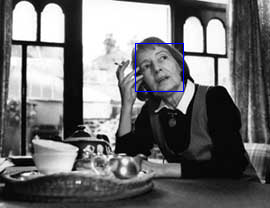

In [ ]:
# Проверим как выглядят фото чтобы понять соответствуют ли данные в наших списках друг другу
# Можно поменять num на любое другое число, чтобы посмотреть другое фото и его данные

num = 10614
path_ = '/content/wiki/' + meta['wiki'][0]["full_path"][0][0][num][0]
gen_ = meta['wiki'][0]['gender'][0][0][num]

dobs = meta['wiki'][0]['dob'][0][0][num]
takens = meta['wiki'][0]['photo_taken'][0][0][num]
age_ = calc_age(takens, dobs)

face_score_ = meta['wiki'][0]['face_score'][0][0][num]
face = face_location[num]
pt1, pt2 = (face[0], face[3]), (face[2], face[1])
name = meta['wiki'][0]['name'][0][0][num][0]

print(f'path = {path_}\ngen = {gen_}\nage = {age_}\nface_score = {face_score_}\
 \nname = {name}')
example = cv2.imread(path_)
example = cv2.rectangle(example, pt1, pt2, color=(255, 0, 0))
example[...,::-1]

Теперь посмотрим на распределение характеристики **face_score**

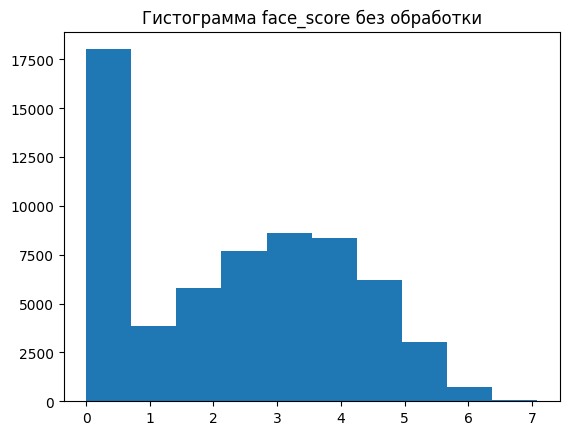

In [ ]:
plt.hist([i if not i<0 else 0 for i in meta['wiki'][0]['face_score'][0][0]])
plt.title('Гистограмма face_score без обработки')
plt.show()

Видим что есть очень много изображений, у которых характеристика **face_score** меньше 0,5. Эта характеристика указывает на качетсво детекции лица на изображении. Для нашей задачи данные должны быть репрезентативными, иначе модели, которые мы будем строить, не смогут эффективно обучаться.

Поэтому мы должны удалить изображения где **face_score** < 0,5

In [ ]:
# Фильтруем данные и создаем на их основе новые списки (чтобы не нарушить структуру данных)
filtered_face_score = [score for i, score in enumerate(face_score) if score >= 0.5]
filtered_face_location = [location for i, location in enumerate(face_location) if face_score[i] >= 0.5]
filtered_sec_face_score = [score for i, score in enumerate(sec_face_score) if face_score[i] >= 0.5]
filtered_full_path = [path for i, path in enumerate(full_path) if face_score[i] >= 0.5]
filtered_age = [age[i] for i, score in enumerate(face_score) if score >= 0.5]
filtered_genders = [gender for i, gender in enumerate(genders) if face_score[i] >= 0.5]

# Проверяем, сколько элементов было отфильтровано
num_removed = len(face_score) - len(filtered_face_score)
print("Отфильтровано:", num_removed, "элементов")

# Переопределяем исходные списки
face_score = filtered_face_score
face_location = filtered_face_location
sec_face_score = filtered_sec_face_score
full_path = filtered_full_path
age = filtered_age
genders = filtered_genders

# Удаляем лишнее
del filtered_face_score
del filtered_face_location
del filtered_sec_face_score
del filtered_full_path
del filtered_age
del filtered_genders

Отфильтровано: 18016 элементов


Посмотрим все ли корректно мы выполнили, не нарушилась ли структура наших данных.

/content/wiki/03/56103_1902-09-20_1966.jpg
0.0
63
2.1232060689332704


array([[[ 41,  41,  41],
        [ 32,  32,  32],
        [ 23,  23,  23],
        ...,
        [168, 168, 168],
        [175, 175, 175],
        [209, 209, 209]],

       [[ 40,  40,  40],
        [ 30,  30,  30],
        [ 22,  22,  22],
        ...,
        [159, 159, 159],
        [159, 159, 159],
        [187, 187, 187]],

       [[ 38,  38,  38],
        [ 28,  28,  28],
        [ 20,  20,  20],
        ...,
        [170, 170, 170],
        [166, 166, 166],
        [186, 186, 186]],

       ...,

       [[195, 195, 195],
        [187, 187, 187],
        [173, 173, 173],
        ...,
        [ 88,  88,  88],
        [ 88,  88,  88],
        [ 86,  86,  86]],

       [[167, 167, 167],
        [162, 162, 162],
        [156, 156, 156],
        ...,
        [ 86,  86,  86],
        [ 86,  86,  86],
        [ 84,  84,  84]],

       [[152, 152, 152],
        [150, 150, 150],
        [152, 152, 152],
        ...,
        [ 85,  85,  85],
        [ 85,  85,  85],
        [ 83,  83,  83]]], dtype=uint8)
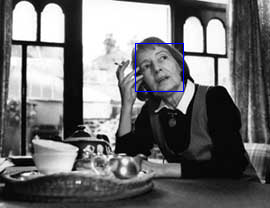

In [ ]:
# В прошлый раз мы печатали фотографию Stevie Smith, у нас сохранилась перменная, которая
# содержить путь к этой фотографии, найдем в нашем списке тот же путь и распечатаем
# Пол,возраст,лицо и само фото должно совпасть с изначальным

for i, img in enumerate(full_path):
  if img == path_:
    face = face_location[i]
    print(img, genders[i], age[i], face_score[i], sep='\n')
    break

pt1, pt2 = (face[0], face[3]), (face[2], face[1])
example = cv2.imread(img)
example = cv2.rectangle(example, pt1, pt2, color=(255, 0, 0))
example[...,::-1]

Все полностью совпадает, значит мы не нарушили структуру данных.

Теперь еще раз провеприм распределение **face_score** но уже после обработки. Все ненужные изображения были удалены.

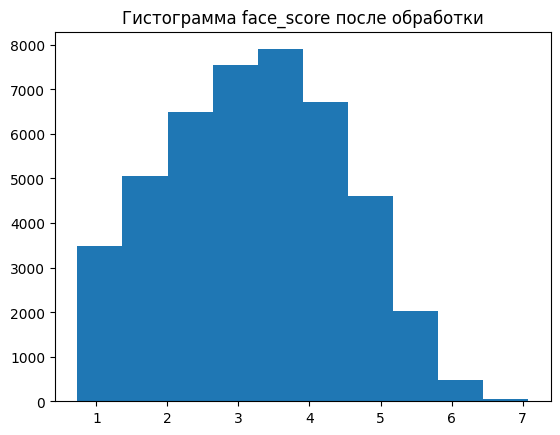

In [ ]:
plt.hist(face_score)
plt.title('Гистограмма face_score после обработки')
plt.show()

## Удаляем 4096 случаев, когда `second_face_score не равен nan`, то есть на изображении больше 1 лица

Посмотрим на распределение **sec_face_score**, видим что присутствует много данных, на которых больше 1 человека, такое нам не подходит.

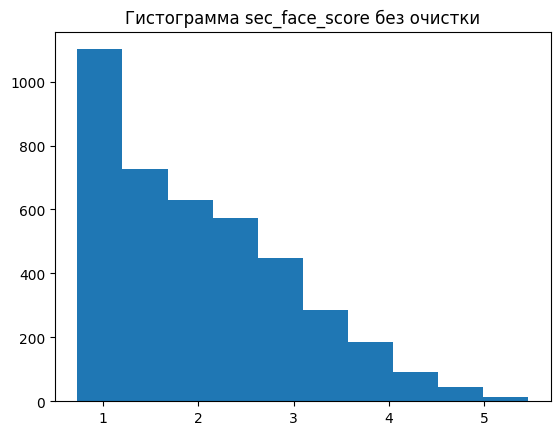

In [ ]:
plt.hist([i for i in meta['wiki'][0]['second_face_score'][0][0]])
plt.title('Гистограмма sec_face_score без очистки')
plt.show()

В дальнейшем мы будем неоднократно удалять изображения по какому-либо условию, поэтому сейчас напишем небольшую функцию `filter_lists`, которая будет удалять все ненужные изображения.

In [ ]:
def filter_lists(lists, condition):
    """
    Фильтрует списки по заданному условию.

    Работа функции:
    1. Создается список пустых списков `filtered_lists` с таким же количеством списков,
    как и входной список `lists`.
    2. Для каждого элемента, полученного из zip объекта, формируется кортеж `item`.
    3. Для каждого кортежа `item` проверяется условие, вызывая функцию `condition(*item)`.
    4. Если результат проверки условия равен False, элементы из каждого списка в `lists`
    добавляются в соответствующий список в `filtered_lists`.
    5. Возвращается отфильтрованный список списков `filtered_lists`.

    Параметры:
    lists (list): Список списков, которые нужно отфильтровать.
    condition (function): Функция, принимающая аргументы из каждого списка и
        возвращающая True или False в зависимости от того, должен ли элемент быть включен
        в результирующий список.

    Возвращает:
    list: Список списков, содержащий элементы из исходных списков, удовлетворяющие условию.

    Пример использования:
    >>> lists = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
    >>> condition = lambda x, y, z: x + y + z > 10
    >>> filter_lists(lists, condition)
    [[4, 5, 6], [7, 8, 9]]
    """
    filtered_lists = [[] for _ in lists]
    for i, item in enumerate(zip(*lists)):
        if not condition(*item):
            for j, l in enumerate(filtered_lists):
                l.append(lists[j][i])
    print(f"Удалено: {len(lists[0])-len(filtered_lists[0])} элементов")
    return filtered_lists

In [ ]:
def condition(face_score, face_location, sec_face_score, full_path, age, gender):
  """
  Определяет условие фильтрации для списка элементов на основе заданных критериев.
  Для каждого удаления нужно написать свое условие в return.

  Параметры:
  - face_score (float): Оценка лица на изображении.
  - sec_face_score (float): Оценка второго лица на изображении.
  - full_path (str): Полный путь к изображению.
  - age (int): Возраст человека на изображении.
  - gender (str): Пол человека на изображении.

  Возвращает:
  - bool: True, если элемент должен быть включен в результирующий список,
    False в противном случае.

  Пример использования:
  >>> condition(0.9, 0.8, 'path/to/image.jpg', 25, 'male')
  True
  >>> condition(0.7, np.nan, 'path/to/another_image.jpg', 32, 'female')
  False
  """
  return not np.isnan(sec_face_score)

In [ ]:
# Применяем функцию
face_score, face_location, sec_face_score, full_path, age, genders \
= filter_lists([face_score, face_location, sec_face_score, full_path, age, genders], condition)

print(len(full_path), len(age), len(genders))

Удалено: 4096 элементов
40216 40216 40216


Для проверки так же напишем функцию

In [ ]:
def proof():
  for i, img in enumerate(full_path):
    if img == path_:
      face = face_location[i]
      print(img, genders[i], age[i], face_score[i], sep='\n')
      break

  pt1, pt2 = (face[0], face[3]), (face[2], face[1])
  example = cv2.imread(img)
  example = cv2.rectangle(example, pt1, pt2, color=(255, 0, 0))
  return example

/content/wiki/03/56103_1902-09-20_1966.jpg
0.0
63
2.1232060689332704


array([[[ 41,  41,  41],
        [ 32,  32,  32],
        [ 23,  23,  23],
        ...,
        [168, 168, 168],
        [175, 175, 175],
        [209, 209, 209]],

       [[ 40,  40,  40],
        [ 30,  30,  30],
        [ 22,  22,  22],
        ...,
        [159, 159, 159],
        [159, 159, 159],
        [187, 187, 187]],

       [[ 38,  38,  38],
        [ 28,  28,  28],
        [ 20,  20,  20],
        ...,
        [170, 170, 170],
        [166, 166, 166],
        [186, 186, 186]],

       ...,

       [[195, 195, 195],
        [187, 187, 187],
        [173, 173, 173],
        ...,
        [ 88,  88,  88],
        [ 88,  88,  88],
        [ 86,  86,  86]],

       [[167, 167, 167],
        [162, 162, 162],
        [156, 156, 156],
        ...,
        [ 86,  86,  86],
        [ 86,  86,  86],
        [ 84,  84,  84]],

       [[152, 152, 152],
        [150, 150, 150],
        [152, 152, 152],
        ...,
        [ 85,  85,  85],
        [ 85,  85,  85],
        [ 83,  83,  83]]], dtype=uint8)
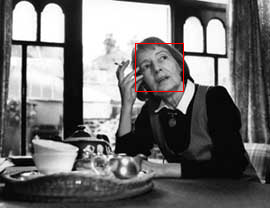

In [ ]:
proof()

Все полностью совпадает

## Удаляем данные где вычисленный возраст `age` отрицательный или превышает 100

Посмотрим на распределение **age**, есть ли вообще такие случаи

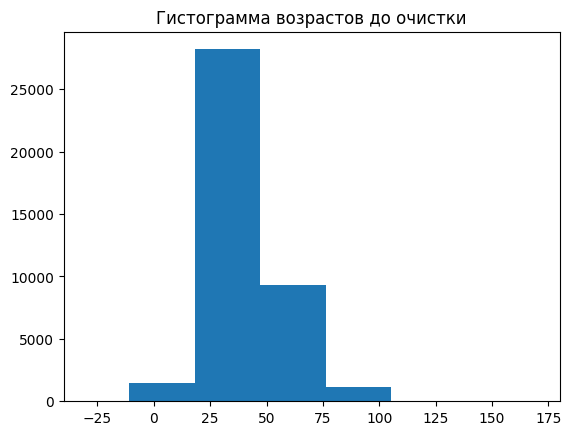

In [ ]:
plt.hist(age, bins=70)
plt.title('Гистограмма возрастов до очистки')
plt.xlim(-40, 180)
plt.show()

Да, такие случаи есть, поэтому избавимся от них.

Изменим условие в функции **condition** и затем просто применим ее.

In [ ]:
def condition(full_path, face_location, age, gender):
    return age<0 or age>100

# Применяем
full_path, face_location, age, genders = filter_lists([full_path, face_location, age, genders], condition)

print(len(full_path), len(age), len(genders))

Удалено: 55 элементов
40161 40161 40161


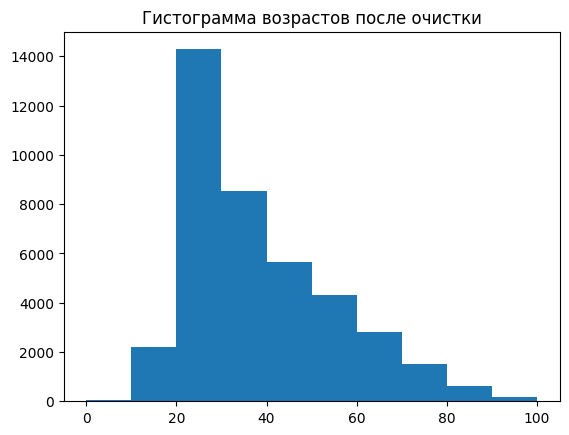

In [ ]:
plt.hist(age)
plt.title('Гистограмма возрастов после очистки')
plt.show()

Данные удалились корректно

## Очистим изображения где нет разметки `gender`, то есть gender = nan

Меняем условие **condition** и применяем функцию

In [ ]:
def condition(full_path, face_location, age, gender):
    return np.isnan(gender)


full_path, face_location, age, genders = filter_lists([full_path, face_location, age, genders], condition)

print(len(full_path), len(face_location), len(age), len(genders))

Удалено: 761 элементов
39400 39400 39400 39400


Дополнительная обработака данных:

## Проверка на корректный размер изображения

Все изображения имеют разный размер, для нас это не хорошо, так как модели ML и NN работают только тогда когда  входные данные имеют одинаковый размер.


Посмотрим на распределение разрешения изображений

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


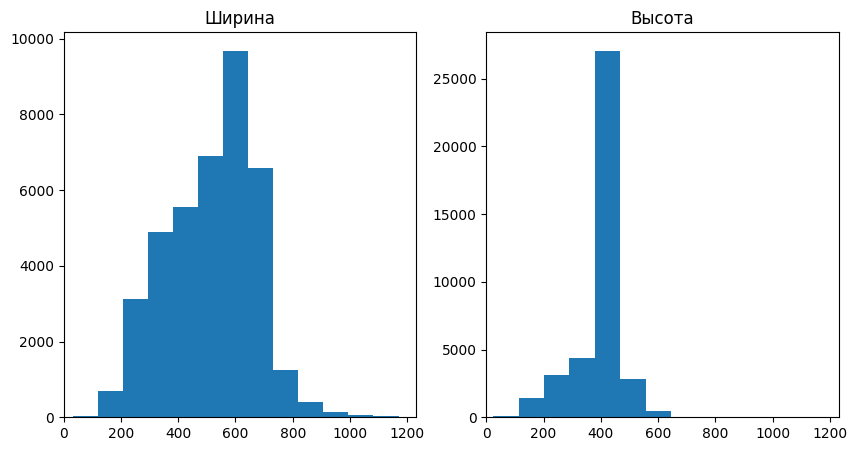

In [ ]:
x,y = [],[]
for i in range(len(full_path)):
  shape_ = plt.imread(full_path[i]).shape
  x.append(shape_[0])
  y.append(shape_[1])
fig = plt.figure(figsize=(10, 5))
for i in range(1, 3):
  subplot = fig.add_subplot(1, 2, i)
  plt.xlim(0, 1230)
  if i == 1:
    plt.hist(x, bins=20)
    plt.title('Ширина')
  else:
    plt.hist(y, bins=20)
    plt.title('Высота')
del x,y

Приводить все изображения к нужному нам соотношению мы будем дальше, перед работой нейросети,а сейчас избавимся от явных выбросов.

Видим что присутствуют изображения, в которых меньше 100 пикселей - будем считать их выбросами.

In [ ]:
def condition(full_path, face_location, age, gender):
    img = cv2.imread(full_path)
    if isinstance(img, np.ndarray):
        height, width, _ = img.shape
        if height >= 100 and width >= 100:
            return False
    return True

full_path, face_location, age, genders = filter_lists([full_path, face_location, age, genders], condition)
print(len(full_path), len(age), len(genders))

Удалено: 54 элементов
39311 39311 39311


/content/wiki/03/56103_1902-09-20_1966.jpg
0.0
63
2.6557568921814765


array([[[ 41,  41,  41],
        [ 32,  32,  32],
        [ 23,  23,  23],
        ...,
        [168, 168, 168],
        [175, 175, 175],
        [209, 209, 209]],

       [[ 40,  40,  40],
        [ 30,  30,  30],
        [ 22,  22,  22],
        ...,
        [159, 159, 159],
        [159, 159, 159],
        [187, 187, 187]],

       [[ 38,  38,  38],
        [ 28,  28,  28],
        [ 20,  20,  20],
        ...,
        [170, 170, 170],
        [166, 166, 166],
        [186, 186, 186]],

       ...,

       [[195, 195, 195],
        [187, 187, 187],
        [173, 173, 173],
        ...,
        [ 88,  88,  88],
        [ 88,  88,  88],
        [ 86,  86,  86]],

       [[167, 167, 167],
        [162, 162, 162],
        [156, 156, 156],
        ...,
        [ 86,  86,  86],
        [ 86,  86,  86],
        [ 84,  84,  84]],

       [[152, 152, 152],
        [150, 150, 150],
        [152, 152, 152],
        ...,
        [ 85,  85,  85],
        [ 85,  85,  85],
        [ 83,  83,  83]]], dtype=uint8)
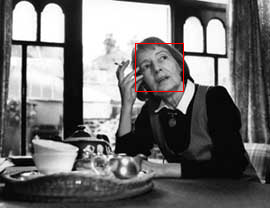

In [ ]:
# Проверка
proof()

## Наличие дубликатов

Так как изображения мы получаем из статей википедии - то нужно учитывать, что разные статьи могут содержать одну и ту же информацию, в таком случае разные статьи будут содержать дубликаты изображений. Проверим есть ли у нас случаи дубликатов.

Мы будем искать дубликаты изображений, используя хэш данные каждого изображения

In [ ]:
import hashlib

hashes = []
def condition(path, location, age, gender):
    """
    Проверяет наличие дубликатов изображений на основе их хэш-значений.

    Работа функции:
    1. Открывает изображение в бинарном режиме и читает его данные.
    2. Вычисляет хэш-значение изображения с использованием алгоритма MD5.
    3. Проверяет, есть ли хэш-значение в списке хэшей `hashes`.
    4. Если хэш-значение не найдено в `hashes`, добавляет его в `hashes`
    и возвращает False, что означает, что изображение не является дубликатом.
    5. Если хэш-значение уже присутствует в `hashes`, возвращает True,
    что означает, что изображение является дубликатом.
    """

    with open(path, 'rb') as f:
      img_data = f.read()

    img_hash = hashlib.md5(img_data).hexdigest()

    if img_hash not in hashes:
      hashes.append(img_hash)
      return False
    else:
      return True

# Применяем функцию
full_path, face_location, age, genders = filter_lists([full_path, face_location, age, genders], condition)
print(len(full_path), len(age), len(genders))

Удалено: 122 элементов
39189 39189 39189


/content/wiki/03/56103_1902-09-20_1966.jpg
0.0
63
2.697044607597101


array([[[ 41,  41,  41],
        [ 32,  32,  32],
        [ 23,  23,  23],
        ...,
        [168, 168, 168],
        [175, 175, 175],
        [209, 209, 209]],

       [[ 40,  40,  40],
        [ 30,  30,  30],
        [ 22,  22,  22],
        ...,
        [159, 159, 159],
        [159, 159, 159],
        [187, 187, 187]],

       [[ 38,  38,  38],
        [ 28,  28,  28],
        [ 20,  20,  20],
        ...,
        [170, 170, 170],
        [166, 166, 166],
        [186, 186, 186]],

       ...,

       [[195, 195, 195],
        [187, 187, 187],
        [173, 173, 173],
        ...,
        [ 88,  88,  88],
        [ 88,  88,  88],
        [ 86,  86,  86]],

       [[167, 167, 167],
        [162, 162, 162],
        [156, 156, 156],
        ...,
        [ 86,  86,  86],
        [ 86,  86,  86],
        [ 84,  84,  84]],

       [[152, 152, 152],
        [150, 150, 150],
        [152, 152, 152],
        ...,
        [ 85,  85,  85],
        [ 85,  85,  85],
        [ 83,  83,  83]]], dtype=uint8)
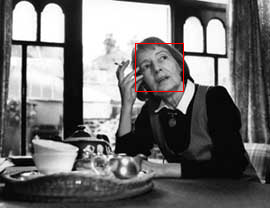

In [ ]:
proof()

## Соотношение классов в датасете

Проблема классового дисбаланса - очень частое явление, которое мешает моделям качественно обучаться и показывать хороший результат работы, проверим есть ли в наших данных дисбаланс.

(array([ 9674.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 29515.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

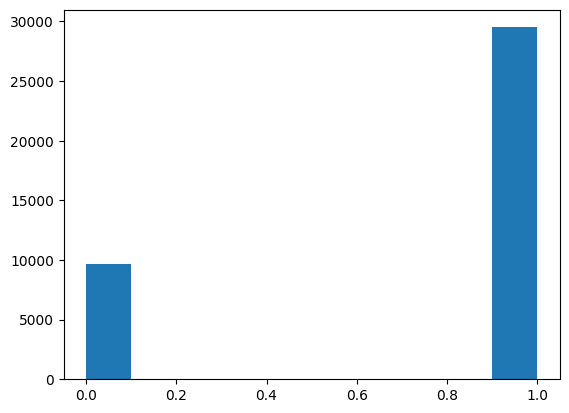

In [ ]:
plt.hist(genders)

Видим что у нас присутствует дисбаланс классов. Эту проблемму мы решим применив аугментацию данных при создании нейросети.

**Мы завершили обработку данных.**

Далее мы будем создавать и обучать ML и NN модели. Обучаясь на большом обьеме данных эти модели могут сильно загружать память рабочей среды `google colab` и в случаях перегрузки полностью отключать нас от сети (удаляя при этои все результаты выполненного кода).

Для того чтобы обезопасить себя от таких ситуаций и не запускать весь код обработки данных заново - сохраним себе на диск файлы уже с обработанными данными.

In [ ]:
# Сохранение списков в текстовые файлы
def save_list_to_file(lst, filename):
    with open(filename, 'w') as f:
        for item in lst:
            f.write(f"{item}\n")

# Пути к файлам
full_path_filename = 'full_path.csv'
face_location_filename = 'face_location.csv'
age_filename = 'age.csv'
genders_filename = 'genders.csv'

# Сохранение списков
save_list_to_file(full_path, full_path_filename)
save_list_to_file(face_location, face_location_filename)
save_list_to_file(age, age_filename)
save_list_to_file(genders, genders_filename)

# 3 Создание моделей

Существует несколько подходов к решению задачи предсказания возраста и пола по фотографии. Мы рассмотрим два основных:

1. **Методы машинного обучения**: использование классических алгоритмов машинного обучения, таких как метод опорных векторов (SVM), случайные леса (random forest) или наивные линейные модели. Мы будем использовать наивную лиейную модель, так как входные данные представляют из себя матрицы большой размерности и модели SVM или RandomForest должны быть слишком сложные чтобы научиться корректно предсказывать целевое значение. Линейная модель в свою очередь будет занимать меньше памяти, обучаться быстрее, и выдавать предсказания также быстрее.

2. **Глубокое обучение**: применение сверточных нейронных сетей (CNN), которые показывают отличные результаты в области анализа изображений.


- Загрузим данные, ранее обработанные нами:

- - Если файлы уже в рабочей директории, то выполнить этот код

In [ ]:
# with open('full_path.csv', 'r') as f:
#   full_path = f.readlines()
# for i,path in enumerate(full_path):
#   full_path[i] = full_path[i][:-1]

# with open('age.csv', 'r') as f:
#   age = f.readlines()
# for i,path in enumerate(age):
#   age[i] = int(age[i][:-1])

# with open('genders.csv', 'r') as f:
#   genders = f.readlines()
# for i,path in enumerate(genders):
#   genders[i] = int(float(genders[i][:-1]))

- - Если файлы на гугл диске, то выполнить этот код

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# with open('/content/drive/MyDrive/Нетология/Diploma/сборка/full_path.csv', 'r') as f:
#   full_path = f.readlines()
# for i, _ in enumerate(full_path): full_path[i] = full_path[i][:-1]

# with open('/content/drive/MyDrive/Нетология/Diploma/сборка/age.csv', 'r') as f:
#   age = f.readlines()
# for i, _ in enumerate(age):
#   if int(age[i][:-1]) == 0: age[i] = 70
#   else: age[i] = int(age[i][:-1])

# with open('/content/drive/MyDrive/Нетология/Diploma/сборка/genders.csv', 'r') as f:
#   genders = f.readlines()
# for i, _ in enumerate(genders):  genders[i] = int(float(genders[i][:-1]))

Mounted at /content/drive


## 3.1 Логистическая регрессия для предсказания пола и линейная регрессия для предсказания возраста (наивная модель)

Перед созданием и работой с моделями обязательно сделаем все изображения одинакового размера, а так же удалим шумы. Для этого применим фильтр к каждому изображению.

В нашем случае для обработки всех 39189 изображений более подходящим будет медианный фильтр.Обычно он хорошо справляется с удалением шума, сохраняя при этом границы и детали объектов на изображении. Он также более эффективен с точки зрения вычислительной нагрузки, чем билатеральный фильтр и гауссовское размытие.

Почему? - Медианный фильтр имеет линейную алгоритмическую сложность, что означает, что его время выполнения пропорционально размеру окна фильтрации или количеству пикселей в изображении. В то время как у билатерального фильтра и гауссовского размытия время выполнения зависит от размера окна фильтрации и стандартного отклонения.

In [ ]:
for path in full_path:
  image = cv2.imread(path)
  image = cv2.resize(image, (256,256))
  filtered_image = cv2.medianBlur(image, 1)
  cv2.imwrite(path, filtered_image)

Напишем функцию-генератор данных и разделим данные на обучение,валидацию и тест.

In [ ]:
from sklearn.model_selection import train_test_split

def image_generator(paths, genders, batch_size):
  """
  image_generator - генератор, который постепенно загружает батчи изображений
  из списка путей paths и их соответствующие метки genders.
  Каждый путь к изображению считывается с помощью OpenCV, преобразуется в
  нормализованную матрицу и добавляется в текущий батч.

  Этот генератор можно передать в метод fit_generator модели LogisticRegression
  вместо использования fit, чтобы обучить модель поэтапно, не загружая все данные в память сразу.

  Параметры:
    paths (list): Список путей к изображениям.
    genders (list): Список меток пола для каждого изображения.
    batch_size (int): Размер батча, количество изображений в одном батче.

  Возвращает:
    tuple: Кортеж, содержащий нормализованные матрицы изображений
    и соответствующие им метки пола.

  """
  num_samples = len(paths)
  while True:
      for offset in range(0, num_samples, batch_size):
          batch_paths = paths[offset: offset + batch_size]
          batch_genders = genders[offset: offset + batch_size]
          batch_images = []
          for path in batch_paths:
              img = cv2.imread(path)[...,::-1].astype(float) / 255.0
              batch_images.append(img)
          yield np.array(batch_images), np.array(batch_genders)

In [ ]:
# Перед разделением данных необходимо оставить часть для теста (возьмем 5% от датасета на тест)
path_test = full_path[int(len(full_path)*0.95): ]
path_train = full_path[: int(len(full_path)*0.95)]

genders_test = genders[int(len(genders)*0.95): ]
genders_train = genders[: int(len(genders)*0.95)]

age_test = age[int(len(age)*0.95): ]
age_train = age[: int(len(age)*0.95)]

In [ ]:
# Разделение данных на обучающий и валидационный наборы genders
x_train, x_val, y_train_genders, y_val_genders = train_test_split(path_train, genders_train,
                                                    train_size=0.8,
                                                    random_state=123)

# Разделение данных на обучающий и валидационный наборы age
x_train, x_val, y_train_age, y_val_age = train_test_split(path_train, age_train,
                                                    train_size=0.8,
                                                    random_state=123)

1 60


array([[[254, 255, 239],
        [254, 255, 239],
        [254, 255, 239],
        ...,
        [158, 160, 159],
        [155, 159, 158],
        [154, 158, 157]],

       [[254, 255, 239],
        [254, 255, 239],
        [253, 254, 238],
        ...,
        [158, 160, 159],
        [154, 158, 157],
        [155, 159, 158]],

       [[254, 255, 239],
        [254, 255, 239],
        [253, 254, 238],
        ...,
        [157, 159, 158],
        [154, 158, 157],
        [156, 160, 159]],

       ...,

       [[ 92, 100, 103],
        [ 59,  67,  70],
        [ 59,  67,  70],
        ...,
        [ 32,  35,  40],
        [ 33,  38,  42],
        [ 39,  44,  48]],

       [[ 92, 100, 103],
        [ 59,  67,  70],
        [ 61,  69,  72],
        ...,
        [ 32,  35,  40],
        [ 33,  38,  42],
        [ 39,  44,  48]],

       [[ 92, 100, 103],
        [ 60,  68,  71],
        [ 63,  71,  74],
        ...,
        [ 30,  33,  38],
        [ 30,  35,  39],
        [ 36,  41,  45]]], dtype=uint8)
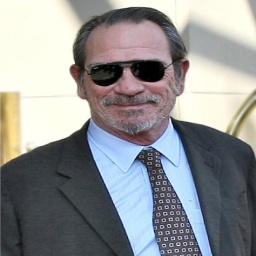

In [ ]:
# Проверим совпадают ли данные (меняем num и оцениваем визуально)
num = 129
print(y_train_genders[num], y_train_age[num])
cv2.imread(x_train[num])[...,::-1]

Мы подготовили данные и создали генератор изображений, теперь можем перейти к написанию модели для предсказания пола и возраста.

- Логистическая регрессия для предсказание пола

In [ ]:
batch_size = 32
input_shape = (256, 256, 3)
num_classes = 2

# Создание модели
GenderModel = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=input_shape), # Преобразуем все 3 матрицы в 1 вектор
                                    tf.keras.layers.Dense(num_classes, activation='softmax')]) # Передаем вектор в полносвязный слой с активацией softmax

# Компиляция модели
GenderModel.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy','binary_accuracy', 'f1_score'])

# Задаем генераторы данных
steps_per_epoch = len(x_train) // batch_size
validation_steps = len(x_val) // batch_size
train_generator = image_generator(x_train, y_train_genders, batch_size)
val_generator = image_generator(x_val, y_val_genders, batch_size)

# Запускаем обучение модели
GenderModel.fit(train_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          validation_data=val_generator,
          validation_steps=validation_steps)

Epoch 1/10
932/932 [==============================] - 185s 198ms/step - loss: 5.8665 - accuracy: 0.6477 - val_loss: 2.4453 - val_accuracy: 0.6038
Epoch 2/10
932/932 [==============================] - 186s 199ms/step - loss: 5.2753 - accuracy: 0.6589 - val_loss: 2.6493 - val_accuracy: 0.6671
Epoch 3/10
932/932 [==============================] - 177s 190ms/step - loss: 4.9818 - accuracy: 0.6666 - val_loss: 6.3615 - val_accuracy: 0.7432
Epoch 4/10
932/932 [==============================] - 165s 177ms/step - loss: 4.3400 - accuracy: 0.6770 - val_loss: 3.9221 - val_accuracy: 0.7481
Epoch 5/10
932/932 [==============================] - 165s 177ms/step - loss: 4.2065 - accuracy: 0.6782 - val_loss: 3.1044 - val_accuracy: 0.7297
Epoch 6/10
932/932 [==============================] - 165s 177ms/step - loss: 4.1478 - accuracy: 0.6836 - val_loss: 3.8177 - val_accuracy: 0.7425
Epoch 7/10
932/932 [==============================] - 154s 166ms/step - loss: 5.0084 - accuracy: 0.6840 - val_loss: 4.8107 -

- линейная регрессия для предсказания возраста

In [ ]:
batch_size = 32
input_shape = (256, 256, 3)
num_classes = 1

# Создание модели
AgeModel = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=input_shape), # Преобразуем все 3 матрицы в 1 вектор
                                    tf.keras.layers.Dense(num_classes, activation='linear')]) # Передаем вектор в полносвязный слой с активацией linear

# Компиляция модели
AgeModel.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy', 'mean_absolute_error'])

# Задаем генераторы данных
steps_per_epoch = len(x_train) // batch_size
validation_steps = len(x_val) // batch_size
train_generator = image_generator(x_train, y_train_age, batch_size)
val_generator = image_generator(x_val, y_val_age, batch_size)

# Запускаем обучение модели
AgeModel.fit(train_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=5,
          validation_data=val_generator,
          validation_steps=validation_steps)

Epoch 1/5
932/932 [==============================] - 179s 192ms/step - loss: 405.9832 - accuracy: 6.7060e-05 - mean_absolute_error: 15.8331 - val_loss: 393.4776 - val_accuracy: 0.0000e+00 - val_mean_absolute_error: 15.1761
Epoch 2/5
932/932 [==============================] - 160s 172ms/step - loss: 384.2532 - accuracy: 6.7060e-05 - mean_absolute_error: 15.4383 - val_loss: 401.9578 - val_accuracy: 0.0000e+00 - val_mean_absolute_error: 15.3494
Epoch 3/5
932/932 [==============================] - 170s 183ms/step - loss: 374.2835 - accuracy: 6.7060e-05 - mean_absolute_error: 15.2328 - val_loss: 406.3647 - val_accuracy: 0.0000e+00 - val_mean_absolute_error: 15.4416
Epoch 4/5
932/932 [==============================] - 156s 167ms/step - loss: 365.8933 - accuracy: 6.7060e-05 - mean_absolute_error: 15.0569 - val_loss: 409.8231 - val_accuracy: 0.0000e+00 - val_mean_absolute_error: 15.5158
Epoch 5/5
932/932 [==============================] - 145s 156ms/step - loss: 358.4530 - accuracy: 6.7060e-05

Теперь сделаем предсказания пола и возраста на отложенных данных

In [ ]:
pred = []
for i in path_test:
  image = cv2.imread(i)[...,::-1].astype(float) / 255.0
  image = np.expand_dims(image, axis=0)
  pred_gen = GenderModel.predict(image)
  pred_age = AgeModel.predict(image)
  pred.append((pred_gen, pred_age))

In [ ]:
gender_prediction = []
for i in pred:
  if i[0][0,0] > i[0][0,1]: gender_prediction.append(0)
  else: gender_prediction.append(1)

age_prediction = []
for i in pred:
  age_prediction.append(int(i[1][0,0]))

del pred

Проверим предсказания

Реальный пол = М, возраст = 45
Предсказанный пол = М, возраст = 37


array([[[197, 188, 193],
        [197, 188, 193],
        [198, 189, 194],
        ...,
        [200, 198, 209],
        [199, 197, 208],
        [199, 197, 208]],

       [[197, 188, 193],
        [198, 189, 194],
        [199, 190, 195],
        ...,
        [201, 199, 210],
        [200, 198, 209],
        [200, 198, 209]],

       [[198, 189, 194],
        [199, 190, 195],
        [199, 190, 195],
        ...,
        [202, 200, 211],
        [201, 199, 210],
        [201, 199, 210]],

       ...,

       [[220, 201, 197],
        [221, 202, 198],
        [221, 203, 199],
        ...,
        [  2,   0,   3],
        [  4,   2,   5],
        [  9,   7,  10]],

       [[219, 200, 194],
        [221, 202, 196],
        [219, 202, 195],
        ...,
        [  2,   0,   3],
        [  5,   3,   6],
        [ 11,   9,  12]],

       [[218, 199, 193],
        [220, 201, 195],
        [218, 201, 194],
        ...,
        [  3,   1,   4],
        [  6,   4,   7],
        [ 13,  11,  14]]], dtype=uint8)
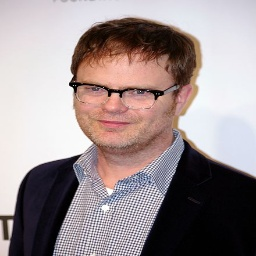

In [ ]:
# Проверим визуально как предсказывает модель
num = 1111
print(f'Реальный пол = {"М" if genders_test[num]==1 else "W"}, возраст = {age_test[num]}')
print(f'Предсказанный пол = {"М" if gender_prediction[num]==1 else "W"}, возраст = {age_prediction[num]}')
cv2.imread(path_test[num])[...,::-1]

Посмотрим основные метрики точности наших предсказаний

In [ ]:
from sklearn.metrics import accuracy_score
gen_accuracy = accuracy_score(genders_test, gender_prediction)
print(f'Точность предсказаний гендера на тестовых данных = {gen_accuracy:.2f}%')

Точность предсказаний гендера на тестовых данных = 0.74%


In [ ]:
from sklearn.metrics import mean_absolute_error
age_mae = mean_absolute_error(age_test, age_prediction)
print(f'Разброс предсказаний возраста на тестовых данных = {age_mae:.0f}')

Разброс предсказаний возраста на тестовых данных = 16


Итог:

Наивная линейная модель научилась предсказывать пол и возраст человека по изображению, с точностью **74%** что значительно лучше случайных угадываний и с разбросом предсказанного возраста **+- 16 лет** от целевого возраста - а вот это уже не так хорошо, мы хотим чтобы возраст предсказывался с погрешностью в **1-2 года**.

In [ ]:
AgeModel.save('AgeModel.keras')
GenderModel.save('GenderModel.keras')

## 3.2 Модель сверточной нейронной сети (CNN)

Для работы больших нейросетей нужно много свободного места на компьютере, в том числе ОЗУ. Постараемся очистить всю память, которую ранее занимали.

Полностью удалим из директории все файлы, которые отсеелись при очистке данных

In [ ]:
for i in os.listdir('/content/wiki'):
  if '.mat' in i:continue
  for img in os.listdir('/content/wiki/'+f'{i}'):
    if '/content/wiki/'+i+'/'+img not in full_path:
      os.remove('/content/wiki/'+i+'/'+img)
      continue

Для этих нейросетей мы будем использовать другой генератор - `tensorflow.keras.preprocessing.image.ImageDataGenerator`, для него нужно чтобы каждое целевое значение лежало в своей директории. Тогда генератор сам определит классы для предсказаний.

Изменяем имена файлов изображений, добавив возраст в конец имени файла. Для этого проходимся по списку **full_path**, извлекаем имя файла из каждого пути, добавляем к нему возраст и обновляем путь к файлу с новым именем.

Кроме всего прочего мы выполним корректировку наших изображений, сейчас изображения могут быть разного размера и люди могут находиться в разных местах фото, людей может быть много или вообще не быть ни одного. Чтобы наша модель все это учитывала - добавим детектор лица `haarcascade_frontalface_default` - он будет находить лицо на изобрежении и далее мы будем обрезать фото только до квадрата 256х256 вокруг этого лица. Таким образом в нейросеть будут поступать только важные для ее работы данные.

Пример работы детектора лиц:

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [103, 103, 103],
        ...,
        [198, 198, 198],
        [120, 120, 120],
        [  0,   0, 255]],

       ...,

       [[  0,   0, 255],
        [  0,   0, 255],
        [148, 148, 148],
        ...,
        [ 84,  84,  84],
        [125, 125, 125],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [148, 148, 148],
        ...,
        [ 90,  90,  90],
        [119, 119, 119],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]]], dtype=uint8)
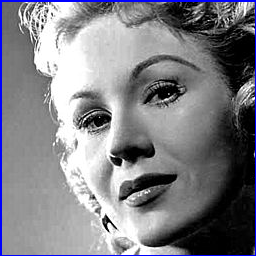

In [ ]:
# Детектор лица
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Нетология/Diploma/Новый/haarcascade_frontalface_default.xml')


for i, image_path in enumerate(full_path[14:]):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,
                                      scaleFactor=1.2,
                                      minNeighbors=2)

    face_boxes = [(i,box_) for i,box_ in enumerate(faces)]
    detections = np.copy(image)

    if len(faces) == 1:
      for (x,y,w,h) in faces:
        center = (x+w//2), (y+h//2)
        pt1 = center[0] - 128, center[1] - 128
        pt2 =  center[0] + 128, center[1] + 128
        cv2.rectangle(detections, pt1, pt2, (255,0,0), 2)
      break

# координаты нижнего правого угла прямоугольника
x1, y1 = pt1
x2, y2 = pt2

# Обрезать изображение по заданным координатам прямоугольника
cropped_image = detections[y1:y2, x1:x2]
cropped_image = cv2.resize(cropped_image, (256,256))
cropped_image[...,::-1]

Применяем детектор и обрезаем фото

In [ ]:
# Пути для кропнутых фото
full_path_crop = []
age = []

# Детектим лицо на изображении
for i, image_path in enumerate(full_path):
  img = cv2.imread(image_path)
  img = cv2.resize(img, (512,512))
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray,
                                    scaleFactor=1.2,
                                    minNeighbors=2)

  if len(faces) != 1:
    continue
  else:
    detections = np.copy(img)

    # координаты верхнего левого и нижнего правого угла прямоугольника для обрезания
    x1, y1 = faces[0][0], faces[0][1]
    x2, y2 = faces[0][0]+faces[0][2], faces[0][1]+faces[0][3]

    # Изменение размера обрезанного изображения до (256, 256)
    cropped_image = detections[y1:y2, x1:x2]
    cropped_image = cv2.resize(cropped_image, (256, 256))

    # Сохранение обрезанного изображения с тем же именем
    cv2.imwrite(image_path, cropped_image)

    # Извлекаем имя файла из пути
    file_name = os.path.basename(image_path)

    # Форматируем новое имя файла с добавлением возраста
    new_file_name = file_name.split('.')[0] + f'({age_[i]}).jpg'

    # Создаем новый путь с обновленным именем файла
    new_image_path = os.path.join(os.path.dirname(image_path), new_file_name)

    # Переименовываем файл
    os.rename(image_path, new_image_path)

    # Заполняем списки для кропнутых изображений
    full_path_crop.append(new_image_path)
    age.append(age_[i])

Данная обработка будет длиться около 1 часа, поэтому ее результат мы сразу запишем себе на диск, чтобы в будущем ничего не ждать, а сразу перейти к анализу.



In [ ]:
import shutil

destination_folder = "/content/drive/MyDrive/Нетология/Diploma/Новый/Фото"  # Путь к целевой папке

# Проверяем, существует ли целевая папка, и создаем ее, если она не существует
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Создаем подпапки от 1 до 100 внутри test_wiki_age
for class_label in list(range(1,101)):
    class_dir = os.path.join(destination_folder, str(class_label))
    os.makedirs(class_dir, exist_ok=True)

# Копируем файлы из исходной директории в целевую
for file_path in full_path_crop:
    file_name = os.path.basename(file_path)  # Получаем имя файла из полного пути
    age_ = file_path.split('(')[-1].split(')')[0] # Получаем возраст
    destination_path = destination_folder +'/'+age_+'/'+file_name # Обьединяем
    shutil.copyfile(file_path, destination_path)  # Копируем файл


# П.С.
# таким образом мы создали на нашем гугл диске папку фото, которая содержит в себе 100 папков
# С именами от 1 до 100, внутри каждой папки находятся обрезанные изображения
# Имя папки - возраст людей на фотографиях внутри нее.
# Например если папка называется 50 - значит внутри нее все фото, на которых людям 50 лет

А теперь все эти папки и фото архивируем, чтобы они занимали меньше места и их было проще и быстрее передавать и скачивать.

In [ ]:
 # Путь к папке, которую нужно скачать
source_folder = "/content/drive/MyDrive/Нетология/Diploma/Новый/Фото"

# Путь к папке на Google Диске, куда нужно загрузить
destination_folder = "/content/drive/MyDrive/"

# Архивируем
shutil.make_archive(destination_folder + 'wiki', 'zip', source_folder)

In [ ]:
# Скачиваем этот архив так же на гугл диск, теперь будем пользоваться только им
!cp -r "/content/drive/MyDrive/wiki.zip" "/content/drive/MyDrive/Нетология/Diploma/Новый/"

### 3.2.1 Сверточная нейросеть, для предсказания пола человека по фото

Теперь разделим все данные на Тренировку, Тест и Валидацию.

Создаем новые директории для хранения тренировочного, валидационного и тестового наборов данных, это необходимо для корректной работы генератора данных, который мы уже совсем скоро создадим - `ImageDataGenerator`

In [ ]:
# Берем 5% данных для тестирования
cut = int(len(full_path)*0.05)
# "Обрезаем" в соотношении 5/95
test_full_path = full_path[-cut:]
test_genders = genders[-cut:]

# Создаем директорию test_wiki для тестовых данных
test_wiki_dir = 'test_wiki'
os.makedirs(test_wiki_dir, exist_ok=True)

# Создаем подпапки 0 и 1 внутри test_wiki
for class_label in ['0', '1']:
    class_dir = os.path.join(test_wiki_dir, class_label)
    os.makedirs(class_dir, exist_ok=True)

for image_path, gender in zip(test_full_path, test_genders):
    # Определяем путь к новому изображению
    new_image_path = os.path.join(test_wiki_dir, str(gender), os.path.basename(image_path))
    # Копируем изображение в соответствующую папку новой директории
    shutil.copy(image_path, new_image_path)

# В исходных переменных full_path и genders удаляем ту часть, которую выделили для test
full_path_ = full_path[:-cut]
genders_ = genders[:-cut]

In [ ]:
# Берем 20% данных для валидации
val_cut = int(len(full_path_)*0.2)
# "Обрезаем" в соотношении 20/80
val_full_path = full_path_[-val_cut:]
val_genders = genders_[-val_cut:]

train_full_path = full_path_[:-val_cut]
train_genders = genders_[:-val_cut]

# Создаем директорию train_wiki для тренировочных данных
train_wiki_dir = 'train_wiki'
os.makedirs(train_wiki_dir, exist_ok=True)

for class_label in ['0', '1']:
    class_dir = os.path.join(train_wiki_dir, class_label)
    os.makedirs(class_dir, exist_ok=True)

for image_path, gender in zip(train_full_path, train_genders):
    new_image_path = os.path.join(train_wiki_dir, str(gender), os.path.basename(image_path))
    shutil.copy(image_path, new_image_path)


# По аналогии создаем директорию val_wiki для валидационных данных
val_wiki_dir = 'val_wiki'
os.makedirs(val_wiki_dir, exist_ok=True)

for class_label in ['0', '1']:
    class_dir = os.path.join(val_wiki_dir, class_label)
    os.makedirs(class_dir, exist_ok=True)

for image_path, gender in zip(val_full_path, val_genders):
    new_image_path = os.path.join(val_wiki_dir, str(gender), os.path.basename(image_path))
    shutil.copy(image_path, new_image_path)

Создаем генераторы изображений для нейросети

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Создаем генератор данных для test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_wiki_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary')

На этапе обработки данных мы говорили что в нашем датасете присутствует дисбаланс классов и мы решили что исправим эту проблему аугментацией данных - поэтому сейчас при создании генератора данных мы добавляем аугментацию.

In [ ]:
# Задаем параметры для аугментации изображений
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Создаем генераторы данных для train и validation
train_generator = train_datagen.flow_from_directory(
    train_wiki_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    val_wiki_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary')

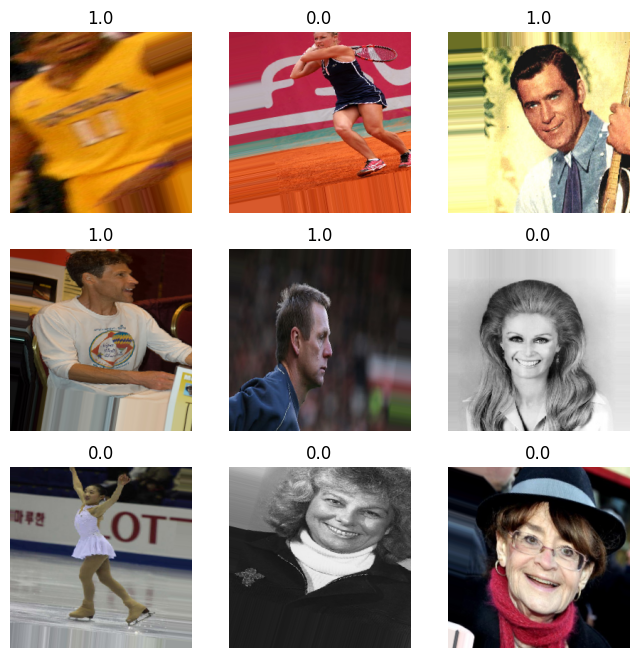

In [ ]:
# первые девять изображений из набора обучающих данных
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_generator:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis("off")
  break

Мы возмьмем модель `ResNet152V2`, которая хорошо зарекомендовала себя в решении задачи поиска информации и закономерностей на фотографиях. Скорректируем ее, для того чтобы она решала нашу задачу определения пола по фото.

In [ ]:
res = ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256,256,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax")

In [ ]:
# Отключаем обучение всем слоям кроме 2 последних
for layer in res.layers[:-2]:
  layer.trainable = False

# Получаем выход из предпоследнего слоя и передаем в наш слой для классификации
x = res.layers[-2].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(2)(x)

# На основе этого создаем модель
resnet_gen_model = tf.keras.Model(inputs=res.input, outputs=x, name='res')

# Компилируем модель
resnet_gen_model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
# Запускаем обучение

epochs=5
resnet_gen_model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    verbose=1)

<ipython-input-19-60887c852942>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet_gen_model.fit_generator(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
# Посмотрим на качество предсказаний модели на отложенных данных
resnet_gen_model.evaluate(
    x=test_generator,
    y=None,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    return_dict=False)

62/62 [==============================] - 1145s 18s/step - loss: 0.2663 - accuracy: 0.8991


[0.26634764671325684, 0.8990825414657593]

Мы получили модель, которая с вероятностью 90% предсказывает пол человека на фото, это отличный показатель, на уровне с самыми лучшими существующими моделями.Особенно учитываем что мы имеем ограниченное кол-во данных и не идеальную разметку.

In [ ]:
# Скачиваем модель на диск
resnet_gen_model.save(f'resnet_gen_model.keras')
!cp -r "/content/resnet_gen_model.keras" "/content/drive/MyDrive/Нетология/Diploma/сборка/"

### 3.2.2 Сверточная нейросеть на основе ResNet и VGG19 для предсказания возраста

Помним, что мы загружали все обработанные и обрезанные изображения себе в архив, поэтому теперь если нужно получить все кропнутые изображения, не важно перезагружали мы среду выполнения или нет - мы просто скачиваем архив из гугл диска и сразу можем приступать к работе.

Чтобы все работало корректно - **советую полностью перезапустить среду выполнения** ("Среда выполнения" -> "Отключиться от среды выполнения и удалить ее"). Затем просто выполнять код ниже.

In [ ]:
import os
import cv2
import json
import datetime
import scipy as sc
import numpy as np
from glob import glob
import tensorflow as tf
from random import shuffle
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Распаковываем архив себе в рабочую директорию в папку wiki
!unzip /content/drive/MyDrive/Нетология/Diploma/Новый/wiki.zip -d /content/wiki

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/wiki/51/45315768_1952-02-14_2003(51).jpg  
  inflating: /content/wiki/51/4535082_1891-12-25_1943(51).jpg  
  inflating: /content/wiki/51/653643_1955-11-29_2007(51).jpg  
  inflating: /content/wiki/51/653852_1957-11-19_2009(51).jpg  
  inflating: /content/wiki/51/1633414_1921-12-05_1973(51).jpg  
  inflating: /content/wiki/51/3633306_1956-06-27_2007(51).jpg  
  inflating: /content/wiki/51/363880_1955-09-01_2007(51).jpg  
  inflating: /content/wiki/51/4633888_1919-04-28_1970(51).jpg  
  inflating: /content/wiki/51/1730445_1954-02-22_2005(51).jpg  
  inflating: /content/wiki/51/18328611_1964-05-21_2015(51).jpg  
  inflating: /content/wiki/51/483018_1959-06-06_2010(51).jpg  
  inflating: /content/wiki/51/39363757_1958-09-29_2010(51).jpg  
  inflating: /content/wiki/51/1041998_1956-11-13_2008(51).jpg  
  inflating: /content/wiki/51/1044945_1918-05-15_1969(51).jpg  
  inflating: /content/wiki/51/20455_1

In [ ]:
# Старые переменные нам больше не нужны, будем пользоваться только 2 новыми
full_path_crop, age = [], []

for folder in os.listdir('/content/wiki/'):
  for imgage in os.listdir('/content/wiki/'+folder):
    full_path_crop.append('/content/wiki/'+folder + '/' + imgage)
    age.append(imgage.split('(')[1].split(')')[0])

Создаем новые директории для хранения тренировочного, валидационного и тестового наборов данных, это необходимо для корректной работы генератора данных, который мы уже совсем скоро создадим - `ImageDataGenerator`

In [ ]:
import shutil
# Берем 5% данных для тестирования
cut = int(len(full_path_crop)*0.05)
# "Обрезаем" в соотношении 5/95
test_full_path = full_path_crop[-cut:]
test_ages = age[-cut:]

# Создаем директорию test_wiki для тестовых данных
test_wiki_dir = 'test_wiki_age'
os.makedirs(test_wiki_dir, exist_ok=True)

# Создаем подпапки от 1 до 100 внутри test_wiki_age
for class_label in list(range(1,101)):
    class_dir = os.path.join(test_wiki_dir, str(class_label))
    os.makedirs(class_dir, exist_ok=True)

for image_path, age_ in zip(test_full_path, test_ages):
    # Определяем путь к новому изображению
    new_image_path = os.path.join(test_wiki_dir, str(age_), os.path.basename(image_path))
    # Копируем изображение в соответствующую папку новой директории
    shutil.copy(image_path, new_image_path)

# В исходных переменных full_path_crop и ages удаляем ту часть, которую выделили для test
full_path_crop = full_path_crop[:-cut]
age = age[:-cut]

In [ ]:
# # Берем 20% данных для валидации
val_cut = int(len(full_path_crop)*0.2)
# "Обрезаем" в соотношении 20/80
val_full_path = full_path_crop[-val_cut:]
val_ages = age[-val_cut:]

train_full_path = full_path_crop[:-val_cut]
train_ages = age[:-val_cut]

# Создаем директорию train_wiki_age для тренировочных данных
train_wiki_dir = 'train_wiki_age'
os.makedirs(train_wiki_dir, exist_ok=True)

for class_label in  list(range(1,101)):
    class_dir = os.path.join(train_wiki_dir, str(class_label))
    os.makedirs(class_dir, exist_ok=True)

for image_path, age_ in zip(train_full_path, train_ages):
    new_image_path = os.path.join(train_wiki_dir, str(age_), os.path.basename(image_path))
    shutil.copy(image_path, new_image_path)


# По аналогии создаем директорию val_wiki_age для валидационных данных
val_wiki_dir = 'val_wiki_age'
os.makedirs(val_wiki_dir, exist_ok=True)

for class_label in  list(range(1,101)):
    class_dir = os.path.join(val_wiki_dir, str(class_label))
    os.makedirs(class_dir, exist_ok=True)

for image_path, age_ in zip(val_full_path, val_ages):
    new_image_path = os.path.join(val_wiki_dir, str(age_), os.path.basename(image_path))
    shutil.copy(image_path, new_image_path)

Создаем генераторы изображений для нейросети

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Создаем генератор данных для test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_wiki_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode="sparse")

Found 1156 images belonging to 100 classes.


На этапе обработки данных мы говорили что в нашем датасете присутствует дисбаланс классов и мы решили что исправим эту проблему аугментацией данных - поэтому сейчас при создании генератора данных мы добавляем аугментацию.

In [ ]:
# Задаем параметры для аугментации изображений
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Создаем генераторы данных для train и validation
train_generator = train_datagen.flow_from_directory(
    train_wiki_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode="sparse")

validation_generator = test_datagen.flow_from_directory(
    val_wiki_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode="sparse")

Found 17572 images belonging to 100 classes.
Found 4392 images belonging to 100 classes.


Посмотрим каким будет результат работы генератора, распечатаем 9 изображений

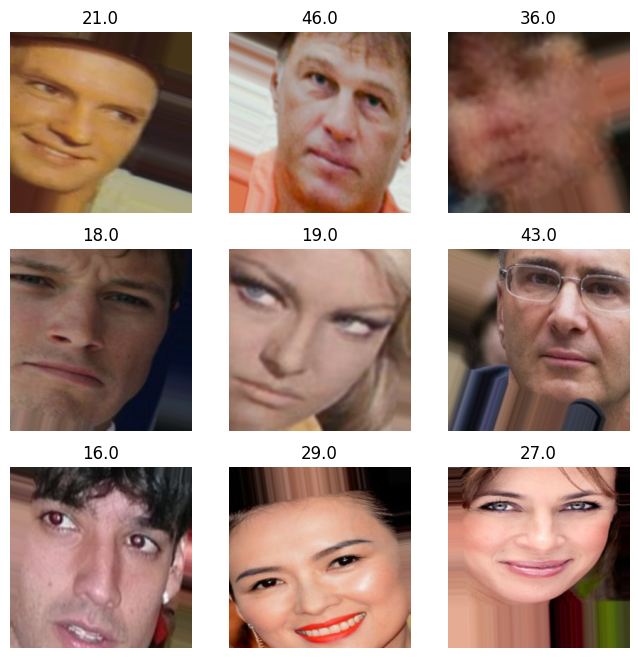

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_generator:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis("off")
  break

**начнем обучение нейросетей:**

Воспользуемся методом TransferLearning, за основу берем 2 нейросети, которые уже обучены находить признаки на фотографиях людей.

- ResNet152V2

- VGG19

- - ResNet152V2

In [ ]:
from keras.applications import ResNet152V2

res = ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256,256,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax")

234545216/234545216 [==============================] - 2s 0us/step


In [ ]:
from keras import regularizers

# Отключаем обучение для всех слоев кроме 2 последних
for layer in res.layers[:-2]:
  layer.trainable = False

# Берем выход из предпоследнего слоя и добавляем свои слои для решения задачи
x = res.layers[-2].output
x = tf.keras.layers.GlobalAveragePooling2D(data_format="channels_last", keepdims=False)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,
                          activation='linear',
                          kernel_regularizer=regularizers.L1L2(l1=1e-6, l2=1e-5),
                          bias_regularizer=regularizers.L2(1e-5),
                          activity_regularizer=regularizers.L2(1e-6))(x)


# На основе этого собираем модель
ResNet_age_model = tf.keras.Model(inputs=res.input, outputs=x, name='res_age')

# Компилируем
ResNet_age_model.compile(
  optimizer='adam',
  loss=tf.losses.MeanSquaredError(),
  metrics=['mean_absolute_error'])

epochs=5

ResNet_age_model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    verbose=0)


# П.С.
# В этой версии ноутбука процесс обучение неросети очищен, так как она обучалась 10 раз,
# Каждый раз по 5 эпох для того чтобы гугл колаб не выдавал ошибку
# История обучения сохранилась, ее можно посмотреть по запросу у автора.

In [ ]:
# Посмотрим на качество предсказаний модели на отложенных данных
ResNet_age_model.evaluate(
    x=test_generator,
    y=None,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    return_dict=False)

37/37 [==============================] - 10s 262ms/step - loss: 195.4191 - mean_absolute_error: 10.0484


[195.41912841796875, 10.048392295837402]

На тестовых данных ошибка mean_absolute_error равна 10, это можно интерпритировать как "среднее отклонение предсказанного возраста от реального"

In [ ]:
# Сохраняем и скачиваем модель на гугл диск
ResNet_age_model.save('ResNet_age_model_crop_10.keras')
!cp -r "/content/ResNet_age_model_crop_10.keras" "/content/drive/MyDrive/Нетология/Diploma/Новый/"

- - VGG19

Выполним аналогичные действия с другой предобученной нейросетью - VGG19

In [ ]:
from keras.applications import VGG19

vgg = VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256,256,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax")

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
from keras import regularizers

for layer in vgg.layers[:-2]:
  layer.trainable = False

x = vgg.layers[-2].output
x = tf.keras.layers.GlobalAveragePooling2D(data_format="channels_last", keepdims=False)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-6, l2=1e-5),
                          bias_regularizer=regularizers.L2(1e-5),
                          activity_regularizer=regularizers.L2(1e-6))(x)

model_age_vgg = tf.keras.Model(inputs=vgg.input, outputs=x, name='vgg_age')

model_age_vgg.compile(
  optimizer='adam',
  loss=tf.losses.MeanSquaredError(),
  metrics=['mae'])

epochs=5

model_age_vgg.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    verbose=0)

In [ ]:
# Посмотрим на качество предсказаний модели на отложенных данных
model_age_vgg.evaluate(
    x=test_generator,
    y=None,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    return_dict=False)

62/62 [==============================] - 1744s 28s/step - loss: 173.2003 - mean_absolute_error: 9.9769


[173.2002716064453, 9.976941108703613]

Здесь качество на тестовых данных чуть лучше, но это можно обьяснить обычной погрешностью. В целом данная НС так же ошибается в своих предсказаниях в среднем на 10 лет.

In [ ]:
model_age_vgg.save('age_model_vgg_crop_9.keras')
!cp -r "/content/age_model_vgg_crop_9.keras" "/content/drive/MyDrive/Нетология/Diploma/Новый/"

**СОЕДИНЕНИЕ AGE МОДЕЛЕЙ** ✅

Сейчас точность предсказания этих моделей нас не устраивает, мы хотим видеть результат намного лучше. Поэтому перейдем к еще одному подходу в создании нейросетей - обьеденим имеющиеся сети в одну.

In [ ]:
resnet_age = tf.keras.models.load_model('/content/drive/MyDrive/Нетология/Diploma/Новый/ResNet_age_model_crop_10.keras')
vgg_age = tf.keras.models.load_model('/content/drive/MyDrive/Нетология/Diploma/Новый/age_model_vgg_crop_9.keras')

Один из возможных сценариев - простое усреднение предсказаний 1 и 2 моделей, проверим будет ли такой подход эффективен

Напишем функцию, которая будет брать 1 батч из тестового генератора и делать 3 предсказания (включая среднее) для него

In [ ]:
def predict_and_average(test_generator, resnet_model, vgg_model):
  """
  Предсказывает возраст с использованием моделей ResNet и VGG и усредняет предсказания.

  Параметры:
  test_generator (generator): Генератор данных для тестирования
  resnet_model (Model): Обученная модель ResNet
  vgg_model (Model): Обученная модель VGG

  Возвращает:
  tuple: Кортеж из трех элементов:
      - images (list): Список матриц изображений из тестового набора данных
      - average_predictions (list): Список с усредненными предсказаниями
      - labels (list): Список с реальным возрастом

  Пример использования:
  >>> images, predictions, labels = predict_and_average(test_generator, resnet_model, vgg_model)
  """
  images = []
  predictions_resnet = []
  predictions_vgg = []
  labels = []

  # Получаем один батч из test_generator
  batch_data, batch_labels = next(test_generator)

  # Делаем предсказания для каждой модели и сохраняем изображения и предсказания
  for i in range(len(batch_data)):
      image = batch_data[i]
      label = batch_labels[i]

      resnet_prediction = resnet_model.predict(np.expand_dims(image, axis=0),
                                               verbose=0)
      vgg_prediction = vgg_model.predict(np.expand_dims(image, axis=0),
                                         verbose=0)

      images.append(image)
      predictions_resnet.append(resnet_prediction)
      predictions_vgg.append(vgg_prediction)
      labels.append(label)

  # Усредняем предсказания
  average_predictions = [(i + j) // 2 for i, j in zip(predictions_resnet, predictions_vgg)]

  return images, average_predictions, labels


images_batch, averaged_predictions, labels_batch = predict_and_average(test_generator, resnet_age, vgg_age)

Визуализируем результат

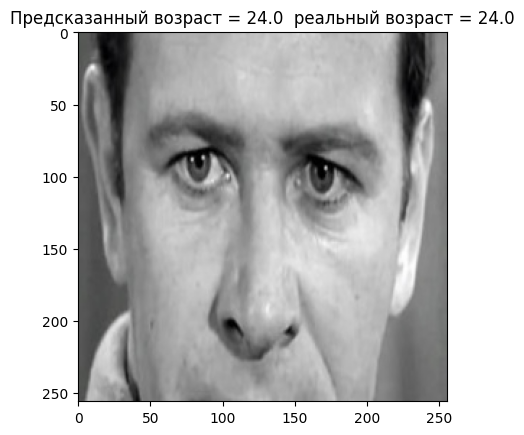

In [ ]:
num = 3
plt.imshow(images_batch[num])
plt.title(f'Предсказанный возраст = {averaged_predictions[num][0][0]}\
  реальный возраст = {labels_batch[num]}')
plt.show()

Напишем еще одну функцию, чтобы взять определенное кол-во данных из наших генераторов и посчитать метрики на этих данных.

In [ ]:
def evaluate_multiple_batches(test_generator, resnet_model, vgg_model, num_batches=1):
  """
  Оценивает результаты предсказания моделей ResNet и VGG на нескольких батчах тестовых данных.

  Параметры:
  test_generator (generator): Генератор данных для тестирования, возвращающий батчи изображений и меток.
  resnet_model (Model): Обученная модель ResNet
  vgg_model (Model): Обученная модель VGG
  num_batches (int, optional): Количество батчей для оценки

  Возвращает:
  tuple: Кортеж из четырех списков:
      - all_labels (list):  Список с реальным возрастом
      - all_resnet_predictions (list): Список предсказаний модели ResNet
      - all_vgg_predictions (list): Список предсказаний модели VGG
      - all_averaged_predictions (list): Список усредненных предсказаний

  Пример использования:
  >>> all_labels, resnet_preds, vgg_preds, avg_preds = evaluate_multiple_batches(test_generator, resnet_model, vgg_model, num_batches=3)
  """
  all_labels = []
  all_resnet_predictions = []
  all_vgg_predictions = []
  all_averaged_predictions = []

  for _ in range(num_batches):
      batch_data, batch_labels = next(test_generator)

      resnet_predictions = resnet_model.predict(batch_data,verbose=0)
      vgg_predictions = vgg_model.predict(batch_data,verbose=0)

      # Усреднение предсказаний
      averaged_predictions = (resnet_predictions + vgg_predictions) / 2

      all_labels.extend(batch_labels)
      all_resnet_predictions.extend(resnet_predictions)
      all_vgg_predictions.extend(vgg_predictions)
      all_averaged_predictions.extend(averaged_predictions)

  return all_labels, all_resnet_predictions, all_vgg_predictions, all_averaged_predictions


num_batches_to_evaluate = 50
labels, resnet_preds, \
vgg_preds, avg_preds = evaluate_multiple_batches(test_generator, resnet_age,\
                                                 vgg_age, num_batches_to_evaluate)



In [1]:
from sklearn.metrics import mean_absolute_error as mae

mae(labels, avg_preds)

5.954208


Замечательно, применив простое усреднение предсказаний, мы получили метрику ошибки **mae 5.95**, что почти в 2 раза лучше в сравнении с результатами каждой из моделей по-отдельности.

Теперь мы попробуем не просто взять среднее между 2 моделями, а построить на их основе новую нейросеть.

In [ ]:
def create_age_prediction_model():
    # Входной слой для двух чисел
    inputs = tf.keras.Input(shape=(2,))

    # Полносвязный слой с 64 нейронами и функцией активации ReLU
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)

    # Выходной слой с 1 нейроном для предсказания возраста
    outputs = tf.keras.layers.Dense(1, activation='linear')(x)

    # Создание модели
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='age_prediction_model')

    return model


model = create_age_prediction_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Вывод информации о модели
model.summary()

Model: "age_prediction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_22 (Dense)            (None, 64)                192       
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 257 (1.00 KB)
Trainable params: 257 (1.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Обучение модели
x_train = np.array([[pred1, pred2] for pred1, pred2 in zip(resnet_preds, vgg_preds)])
y_train = np.array(labels)
model.fit(x_train, y_train, epochs=5, batch_size=32)

Epoch 1/20
37/37 [==============================] - 1s 4ms/step - loss: 150.0244 - mae: 8.8177
Epoch 2/20
37/37 [==============================] - 0s 3ms/step - loss: 64.8371 - mae: 5.1612
Epoch 3/20
37/37 [==============================] - 1s 5ms/step - loss: 62.5211 - mae: 4.9496
Epoch 4/20
37/37 [==============================] - 0s 4ms/step - loss: 61.3081 - mae: 4.9835
Epoch 5/20
37/37 [==============================] - 0s 3ms/step - loss: 60.6560 - mae: 4.9007
Epoch 6/20
37/37 [==============================] - 0s 4ms/step - loss: 59.9842 - mae: 4.8830
Epoch 7/20
37/37 [==============================] - 0s 3ms/step - loss: 59.6515 - mae: 4.8407
Epoch 8/20
37/37 [==============================] - 0s 3ms/step - loss: 59.5255 - mae: 4.8965
Epoch 9/20
37/37 [==============================] - 0s 3ms/step - loss: 59.9816 - mae: 4.8640
Epoch 10/20
37/37 [==============================] - 0s 3ms/step - loss: 59.1176 - mae: 4.8326
Epoch 11/20
37/37 [==============================] - 0s 3m

Видим что показатель ошибки mae: 4.7356, он даже ниже чем если просто усреднять предсказания 2 моделей. А значит что данная нейросеть справляется с предсказаниями лучше, чем если брать банальное устреднение предсказаний.

Можно сказать что мы добились отличных результатов - у нас получилось сократить среднюю ошибку предсказаний возраста с 10 лет, до 4.7 лет

In [ ]:
# Сохраняем данную модель как лучшую
model.save('best_age_model.keras')
!cp -r "/content/best_age_model.keras" "/content/drive/MyDrive/Нетология/Diploma/Новый/"

Что мы имеем сейчас:

- Готовые ML модели для предсказания пола и возраста с не самой высокой точностью: `GenderModel.keras`, `AgeModel.keras`

- Готовые модели нейросетей для предсказания пола и возраста, они имеют более высокую точность чем ML и так обладают большим простором для улучшения, обьединения или трансформации: `resnet_gen_model.keras`, `ResNet_age_model_crop_10.keras`, `age_model_vgg_crop_9.keras`


- **Лучшая NN модель** для предсказания возраста -> `best_age_model.keras`

На этом этапе мы заканчиваем обработку данных и создание нейросетей.

Теперь мы будем использовать полученные результаты чтобы создать программу с пользовательским интерфейсом, которая определит возраста человека на фотографии. Самый понятный вариант реализации пользовательского интерфейса - телеграм бот, который принимает фото от пользователя и отправляет в ответ результат предсказания нейросети.

# TG bot

Перезагружаем среду выполнения гугл колаба и импортируем всё необходимое.

In [1]:
import os
import cv2
import numpy as np
from glob import glob
import tensorflow as tf
from random import shuffle
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

resnet_model = tf.keras.models.load_model('/content/drive/MyDrive/Нетология/Diploma/Новый/ResNet_age_model_crop_10.keras')
vgg_model = tf.keras.models.load_model('/content/drive/MyDrive/Нетология/Diploma/Новый/age_model_vgg_crop_9.keras')
best_age_model = tf.keras.models.load_model('/content/drive/MyDrive/Нетология/Diploma/Новый/best_age_model.keras')

Mounted at /content/drive


Устанавливаем библиотеку `imagehash` для работы с хэш-данными файлов

In [2]:
!pip install imagehash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 5.4 MB/s eta 0:00:00


Напишем несколько функций, которые будут получать фотографии и обрабатывать их

In [3]:
# Вспомогательная функция, которая будет работать внутри основной

def process_and_save_image(image_,
                           examples_folder="/content/drive/MyDrive/Нетология/Diploma/сборка/examples"):
  """
  Обрабатывает изображение и сохраняет его, если такого изображения раньше не было

  Аргументы:
  image_ (str): Путь к изображению.
  examples_folder (str, optional): Путь к папке, в которую сохраняются примеры.
      По умолчанию "/content/drive/MyDrive/Нетология/Diploma/сборка/examples".

  Примеры использования:
      process_and_save_image("/content/image.jpg")
      process_and_save_image("/content/image.jpg", "/content/examples")
  """


  import imagehash
  from PIL import Image

  # Получаем хеш изображения
  image = Image.open(image_)
  image = image.convert("RGB")
  image_hash = imagehash.average_hash(image)

  # Получаем список файлов в папке examples
  files_in_examples = os.listdir(examples_folder)

  # Проверяем, существует ли файл с таким же хешем в папке examples
  max_file_number = 0
  for file_name in files_in_examples:
    # Ищем максимальный номер файла в папке examples
    file_number = int(file_name.split('.')[0][7:])
    max_file_number = max(max_file_number, file_number)
    # Проверяем чтобы не было копий
    file_name = examples_folder + '/' + file_name
    another = Image.open(file_name)
    another = another.convert("RGB")
    if imagehash.average_hash(another) == image_hash:
      print(f'Файл {file_name} есть в директории')
      break

  else:
    # Генерируем имя нового файла
    new_file_name = f"Example{max_file_number + 1}.jpg"

    # Сохраняем изображение в папку examples
    image.save(os.path.join(examples_folder, new_file_name))
    print(f"Изображение {new_file_name} добавлено в папку examples.")

In [8]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.0 MB/s eta 0:00:00


In [46]:
def how_many(image_path):
  """
  Функция проверяет сколько лиц было обнаружено на фото
  """

  import cv2
  import io
  import numpy as np
  from mtcnn import MTCNN

  # Преобразуем изображение в массив
  image = image1 = cv2.imread(image_path)
  detector = MTCNN()
  faces = detector.detect_faces(image)

  how_many_faces = len(faces)

  if how_many_faces > 1:
    detections = np.copy(image)

    for i, face in enumerate(faces):
      x, y, w, h = face['box']
      # отрисовываем детекцию лиц
      cv2.rectangle(detections,(x,y),(x+w,y+h),(255,0,0), 2)
      img = io.BytesIO()
      plt.imshow(detections[..., ::-1])
      plt.text(x, y, f'{i+1}',
              color='black', fontsize=12,
              fontweight='bold', ha='left',
              va='bottom', backgroundcolor='0.9')
      ax = plt.gca()
      ax.set_axis_off()
      plt.savefig(img, format='png', bbox_inches='tight', pad_inches=0)
    process_and_save_image(img)
    img.seek(0)

  else: img = False

  plt.cla()
  return img, how_many_faces

In [64]:
# Основная функция, принимает фото - выдает результат работы нейросети
def gen_age(image_path, mode='*Standart*', choise=False):
    """
    Функция делает предсказание для одного изображения с помощью двух моделей ResNet и VGG,
    а затем печатает изображение с указанием предсказанного возраста.

    Параметры:
    image_path (str): Путь к изображению.
    """
    import cv2
    import io
    import numpy as np
    from mtcnn import MTCNN

    # Преобразуем изображение в массив
    image = image1 = cv2.imread(image_path)
    detector = MTCNN()
    faces = detector.detect_faces(image)

    if len(faces) > 0:
      detections = np.copy(image)

      for i, face in enumerate(faces):
        x, y, w, h = face['box']
        if choise:
          if i+1 != int(choise): continue
      # отрисовываем детекцию лиц
        cv2.rectangle(detections,(x,y),(x+w,y+h),(255,0,0), 2)

        x1, y1 = x, y
        x2, y2 = x+w, y+h

        img_ = image[y1:y2, x1:x2]
        img_ = cv2.resize(img_, (256, 256))
        img_ = img_ / 255.0


        # Делаем предсказания для каждой модели
        resnet_prediction = resnet_model.predict(np.expand_dims(img_, axis=0), verbose=0)
        vgg_prediction = vgg_model.predict(np.expand_dims(img_, axis=0), verbose=0)
        if mode != '*Standart*':
          predicted_age = int(resnet_prediction[0][0] + vgg_prediction[0][0])//2
        else:
          prepredict = np.array( (resnet_prediction[0][0], vgg_prediction[0][0]) )
          predicted_age = int(best_age_model.predict(np.expand_dims(prepredict, axis=0), verbose=0)[0][0])
        img = io.BytesIO()
        plt.imshow(detections[..., ::-1])
        plt.text(0.5, 1.1, f'Предсказанный возраст: {predicted_age}',
                color='black', fontsize=10,
                  ha='center', fontweight='bold',
                  va='top', transform=plt.gca().transAxes)
        ax = plt.gca()
        ax.set_axis_off()
        plt.savefig(img, format='png', bbox_inches='tight', pad_inches=0.1)

      process_and_save_image(img)
      plt.cla()
      img.seek(0)
      return img


    else: return False

In [6]:
!python -m pip install pyTelegramBotAPI

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.2/232.2 kB 3.3 MB/s eta 0:00:00


In [ ]:
import telebot
import random
from telebot import types


token = "7102479784:AAGtBTO2adSA5Bm-e180IMfIUTqHDb-cpgM"
my_site = 'https://github.com/KirillCKO/GraduateWork'

# Инициализация класса телебота
bot = telebot.TeleBot(token)

help_text = """Бот создан для определения возраста человека на фотографии.\n
Пожалуйста, пришлите ваше фото, а бот попробует предсказать возраст этого человека.\n
На данный момент точность предсказаний зависит от выбранного вами режима работы, \
а так же от качества фотографии.\n
Мы ежедневно работаем над улучшением модели, поэтому будем рады вашей обратной связи\
 она поможет нам улучшить качество предсказаний"""

start_text = f"""Привет, , выбери одну из кнопок для начала работы"""

Standart = "*Standart*"
Average = "*Average*"
global mode
global not_mode
mode = Average
not_mode = Average if mode==Standart else Standart

send_photo_text = """Для предсказания возраста по вашему фото - просто отправьте мне его 😎, других действий не требуется!

Я постоянно совершенствуюсь, поэтому мои предсказания становятся лучше 🧠"""

b_1 = types.KeyboardButton('Отправить фото')
b_2 = types.KeyboardButton('Инфо о боте')
b_3 = types.KeyboardButton('Пример работы')
b_4 = types.KeyboardButton('Исходный код')
b_5 = types.KeyboardButton('Создатель')
b_6 = types.KeyboardButton('Режим работы')


# Обработка сообщения после команд 'start', 'main', 'hello'
@bot.message_handler(commands=['start', 'main', 'hello'])
def start(message, start_text_=start_text):
    "Выводит справочное сообщение при команде /start и показывает клавиатурные кнопки"
    markup = types.ReplyKeyboardMarkup()
    # инициализация кнопок
    but_1 = types.KeyboardButton('Отправить фото')
    but_2 = types.KeyboardButton('Инфо о боте')
    but_3 = types.KeyboardButton('Пример работы')
    but_4 = types.KeyboardButton('Исходный код')
    but_5 = types.KeyboardButton('Создатель')
    but_6 = types.KeyboardButton('Режим работы')
    # Создание рядов с кнопками
    markup.row(but_1, but_2)
    markup.row(but_3, but_4)
    markup.row(but_5, but_6)
    start_text_ = start_text[:8] + message.from_user.first_name + start_text[8:]
    bot.send_message(message.chat.id,
                     start_text_,
                     reply_markup=markup)


# Обработка сообщения после команд 'site', 'code', 'git', 'github'
@bot.message_handler(commands=['site', 'code', 'git', 'github'])
def site(message):
    "Отправляем пользователя на гитхаб с иходным кодом нейросети"
    markup = types.InlineKeyboardMarkup()
    # инициализация кнопок
    but_1 = types.InlineKeyboardButton('Да', my_site)
    but_2 = types.InlineKeyboardButton('Нет', callback_data='cancel')
    # Создание рядов для этих кнопок
    markup.row(but_1)
    markup.row(but_2)
    bot.send_message(message.chat.id,
                     'Хотите перейти на сайт?',
                     reply_markup=markup)


# Декоратор для обработки любой callback_data
@bot.callback_query_handler(func=lambda callback: True)
def callback_message(callback):
    if callback.data == 'cancel':
        bot.delete_message(callback.message.chat.id, callback.message.message_id)
        bot.delete_message(callback.message.chat.id, callback.message.message_id-1)
        bot.send_message(callback.message.chat.id, "Переход на сайт отменен.")
    elif callback.data == 'cancelpredict':
        bot.delete_message(callback.message.chat.id, callback.message.message_id)
        bot.delete_message(callback.message.chat.id, callback.message.message_id-1)
        bot.send_message(callback.message.chat.id, "Обработка фото отменена.")
    elif callback.data == 'switch':
        global mode
        global not_mode
        not_mode = Average if mode==Standart else Standart
        mode = not_mode
        not_mode = Average if mode==Standart else Standart
        bot.delete_message(callback.message.chat.id, callback.message.message_id)
        bot.delete_message(callback.message.chat.id, callback.message.message_id-1)
        bot.send_message(callback.message.chat.id, f"Режим работы изменен на {mode}",
                         parse_mode='markdown')
    elif callback.data == 'notswitch':
        bot.delete_message(callback.message.chat.id, callback.message.message_id)
        bot.delete_message(callback.message.chat.id, callback.message.message_id-1)
        bot.send_message(callback.message.chat.id, "Изменение режима работы отклонено.")


# Команда 'help'
@bot.message_handler(commands=['help'])
def help(message):
    "Выводим справочное сообщение"
    bot.send_message(message.chat.id, help_text)


# Информация о чате
@bot.message_handler(commands=['chatinfo'])
def chatinfo(message):
    "Сообщение о метадате"
    bot.send_message(message.chat.id, message)


# обработка фотографий (предсказание возраста)
@bot.message_handler(content_types=['photo', 'document'])
def neuralnetwork(message, choise=False, id=False):
    "Получает входящее изображение, отправляет предсказание возраста"
    text_ = """Я не могу обработать этот файл. Почему это случилось:
    - Размер файла слишком большой
    - Файл не является фотографией

Поставьте галочку в пункте 'Сжать изображение' перед отправкой"""
    zero_people_text = "Я не вижу людей, простите"
    why_file = """Простите что-то не так с вашим файлом. Я не могу обработать его.
Попробуйте отправить ваш файл в другом формате, например jpg или png """
    global mode
    if '/content/photo.jpg' == message:
      photo_ = gen_age(message, mode=mode, choise=choise)
      bot.send_photo(id, photo_)
    else:
      try:
        try:
          file_id = message.photo[-1].file_id
        except:
          file_id = message.document.file_id
        file_info = bot.get_file(file_id)
        downloaded_file = bot.download_file(file_info.file_path)
        if 'RGB' in str(downloaded_file) or 'JFIF' in str(downloaded_file):
          with open('photo.jpg', 'wb') as new_file:
              new_file.write(downloaded_file)
          image_path = '/content/' + 'photo.jpg'
          file_, num_people = how_many(image_path)
          if num_people == 1:
            photo_ = gen_age(image_path,  mode=mode)
            if photo_:
              bot.send_photo(message.chat.id, photo_)
            else: bot.send_message(message.chat.id, text_)
          elif num_people > 1:
            if str(num_people)[-1] in ['2','3', '4']: people = ' человека'
            else: people = ' человек'
            how_many_text = f"На фото обнаружено {num_people}{people}, кого выбираем?"
            markup = types.ReplyKeyboardMarkup(one_time_keyboard=True)
            but_0 = types.KeyboardButton('1')
            but_1 = types.KeyboardButton('2')
            but_2 = types.KeyboardButton('3')
            but_3 = types.KeyboardButton('4')
            but_4 = types.KeyboardButton('5')
            but_5 = types.KeyboardButton('6')
            but_6 = types.KeyboardButton('7')
            but_7 = types.KeyboardButton('8')
            if num_people == 2: markup.row(but_0, but_1)
            elif num_people == 3: markup.row(but_0, but_1, but_2)
            elif num_people == 4: markup.row(but_0, but_1); markup.row(but_2, but_3)
            elif num_people == 5: markup.row(but_0, but_1); markup.row(but_2, but_3); markup.row(but_4)
            elif num_people == 6: markup.row(but_0, but_1, but_2); markup.row(but_3, but_4, but_5)
            elif num_people == 7: markup.row(but_0, but_1); markup.row(but_2, but_3); markup.row(but_4, but_5); markup.row(but_6)
            elif num_people == 8: markup.row(but_0, but_1); markup.row(but_2, but_3); markup.row(but_4, but_5); markup.row(but_6, but_7)
            bot.send_photo(message.chat.id,
                          file_,
                          caption=how_many_text,
                          reply_markup=markup, )
            # Регистрируем следующую функцию, которая отработает после нажатия на кнопку
            bot.register_next_step_handler(message, on_click,  image_path, message.chat.id)
          else: bot.send_message(message.chat.id, zero_people_text)
        else: bot.send_message(message.chat.id, why_file)
      except:
        bot.send_message(message.chat.id, why_file)
def on_click(message, image_path, id): # Ф-я реагирующая на клик пользователя
  print(image_path, message.text)
  if message.text in ['0','1','2','3','4','5','6','7']:
    neuralnetwork(image_path, message.text, id)



def just_text(message):
    text_ = 'Простите, я не знаю такой команды, пожалуйста выберете одну из кнопок ниже'
    markup = types.ReplyKeyboardMarkup(one_time_keyboard=True)
    but_1 = types.KeyboardButton('Отправить фото')
    but_2 = types.KeyboardButton('Инфо о боте')
    but_3 = types.KeyboardButton('Пример работы')
    but_4 = types.KeyboardButton('Исходный код')
    but_5 = types.KeyboardButton('Создатель')
    but_6 = types.KeyboardButton('Режим работы')
    markup.row(but_1, but_2)
    markup.row(but_3, but_4)
    markup.row(but_5, but_6)
    bot.send_message(message.chat.id, text_, reply_markup=markup)


def example(message):
    # directory = 'Examples/'
    directory = '/content/drive/MyDrive/Нетология/Diploma/сборка/examples/'
    all_images = os.listdir(directory)
    pick = directory + random.choice(all_images)
    file_ = open(pick, 'rb')
    bot.send_photo(message.chat.id, file_)

@bot.message_handler(commands=['mode'])
def switch_mode(message):
  text_ = f"""У меня есть 2 режима работы {Standart} или {Average}. Standart работает более стабильно чем Average.

Однако в некоторых случаях Average может предсказать возраст почти в 2 раза точнее. Вы можете переключаться между этими режимами.

Сейчас возраст предсказывает нейросеть {mode}, хотите переключить режим на {not_mode}?"""
  markup = types.InlineKeyboardMarkup()
  but_1 = types.InlineKeyboardButton('Да', callback_data='switch')
  but_2 = types.InlineKeyboardButton('Нет', callback_data='notswitch')
  markup.row(but_1)
  markup.row(but_2)
  bot.send_message(message.chat.id, text_, reply_markup=markup, parse_mode='markdown')


@bot.message_handler(commands=['creator'])
def creator(message):
  bot.send_message(message.chat.id, "Мой создатель - @Kyryll_ck")


@bot.message_handler(content_types=['text'])
def echo(message):
    if message.text == 'Отправить фото':
      bot.send_message(message.chat.id, send_photo_text)
    elif message.text == 'Инфо о боте': help(message)
    elif message.text == 'Пример работы': example(message)
    elif message.text == 'Исходный код': site(message)
    elif message.text == 'Создатель': creator(message)
    elif message.text == 'Режим работы': switch_mode(message)
    else: just_text(message)


bot.polling(none_stop=True)